# Model 2: Image Augmentation

In [10]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d msambare/fer2013

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 99% 60.0M/60.3M [00:00<00:00, 104MB/s]
100% 60.3M/60.3M [00:00<00:00, 106MB/s]


In [11]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [8]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [12]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'
# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes


# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)


# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


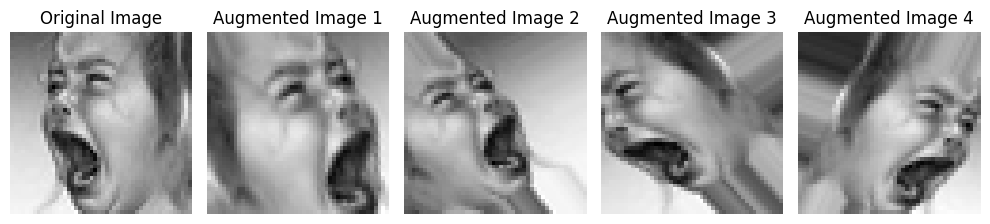

In [13]:
# Path to your specific image
image_path = '/content/train/angry/Training_10290703.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_steps_per_epoch,
#     epochs=100,
#     validation_data=validation_generator,
#     validation_steps=validation_steps_epoch,
#     callbacks=callbacks)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


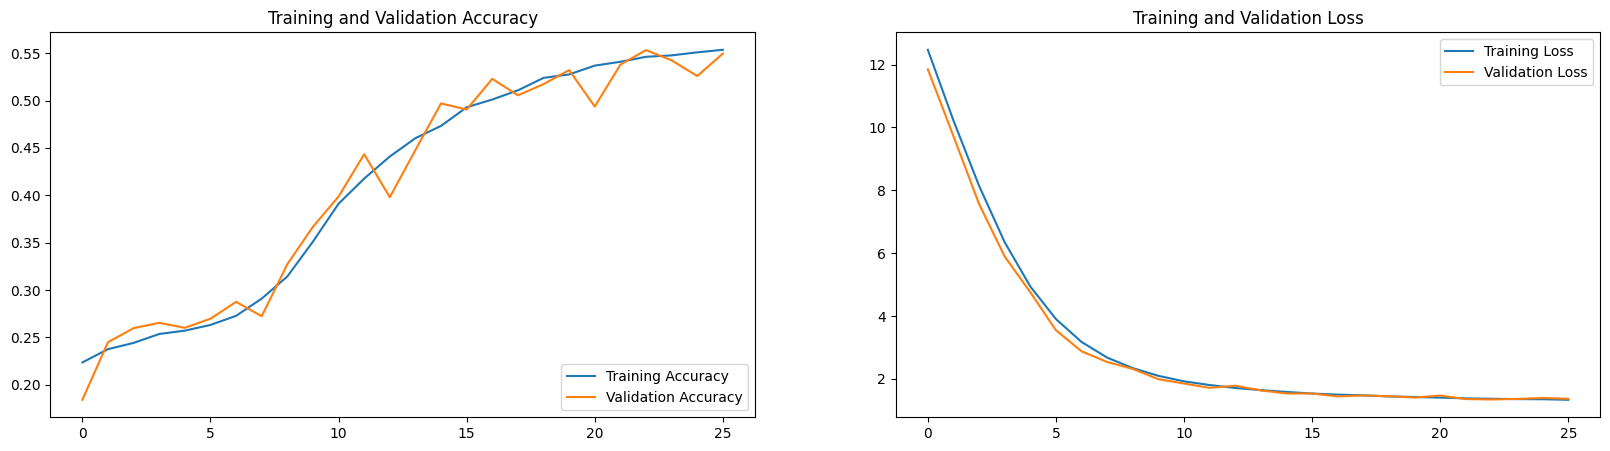

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define the function to plot training history
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A dictionary mimicking the Keras History object's `history` attribute.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Step 2: Load training log and prepare data
log_file = '/content/drive/My Drive/NITK/Mtech NITK/First_year/CS737 Deep Learning/emotionDetection/training_custom_cnn_augmented.log'
# log_file = '/content/training.log'  # Update with the actual path to your log file
log_data = pd.read_csv(log_file)

# Reconstruct the history dictionary
history = {
    'accuracy': log_data['accuracy'].tolist(),
    'val_accuracy': log_data['val_accuracy'].tolist(),
    'loss': log_data['loss'].tolist(),
    'val_loss': log_data['val_loss'].tolist()
}

# Step 3: Plot the training history
plot_training_history(history)


In [17]:
from tensorflow.keras.models import load_model

# Define the path to the model
model_path = '/content/drive/My Drive/NITK/Mtech NITK/First_year/CS737 Deep Learning/emotionDetection/Custom_CNN_augmented_model.h5'

# Load the model
# model = load_model('/content/Custom_CNN_model.h5')
model = load_model(model_path)

# Confirm the model has been loaded
print("Model loaded successfully!")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model loaded successfully!


In [18]:
from tensorflow.keras.optimizers import Adam

# Recompile the model (use the same optimizer and loss as during training)
model.compile(
    optimizer=Adam(),  # Replace with the optimizer used during training
    loss='categorical_crossentropy',  # Replace with the loss used during training
    metrics=['accuracy']  # Ensure metrics are standard
)


In [19]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 590s 2s/step - accuracy: 0.5604 - loss: 1.3227
113/113 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.5873 - loss: 1.2451
final train accuracy = 56.35 , validation accuracy = 58.83


# Plotting Confusion Matrix

113/113 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step


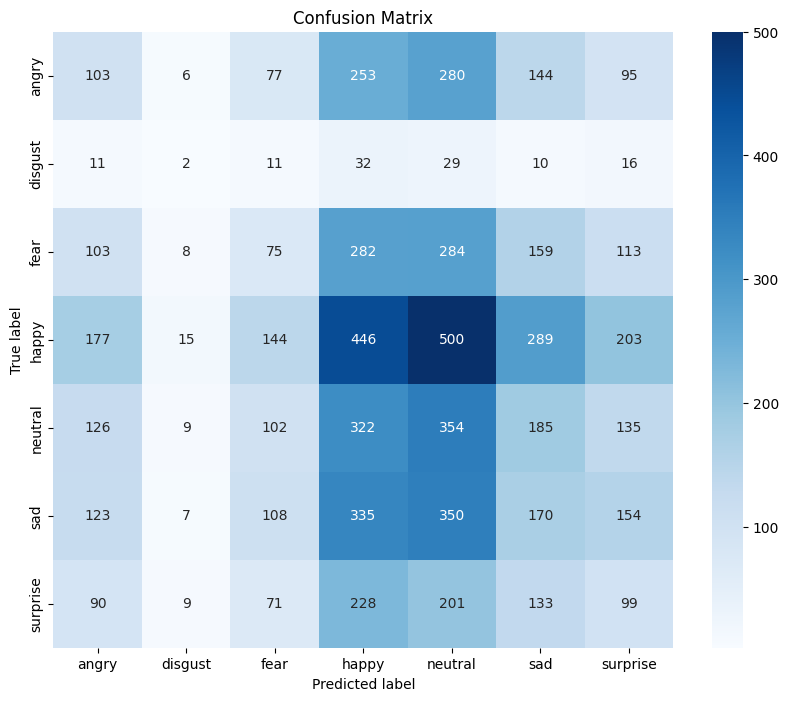

In [20]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [21]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.11      0.12       958
     disgust       0.04      0.02      0.02       111
        fear       0.13      0.07      0.09      1024
       happy       0.23      0.25      0.24      1774
     neutral       0.18      0.29      0.22      1233
         sad       0.16      0.14      0.15      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



**By seeing this comfusion matrix**


*  Overfitting to the Augmented Data:

Augmented samples often resemble the original data too closely. If the model trains heavily on these similar samples, it might memorize them instead of learning to generalize.
*   Overall accuracy is 17%, which is close to random guessing given the number of classes.
*   The support column shows that the number of samples per class varies significantly (e.g., 111 samples for disgust vs. 1774 for happy).


*   Classes with fewer samples (e.g., disgust and surprise) have significantly lower precision, recall, and F1-scores, which suggests the model struggles with these underrepresented classes.
*   All classes have very low precision (e.g., disgust = 0.04) and recall (e.g., fear = 0.07).
<br>The F1-scores, which combine precision and recall, hover around 0.1–0.2 for most classes, showing poor prediction quality across the board.



*   Means by assing augmented image performance not getting improved even though getting dceress as






# Making Predictions

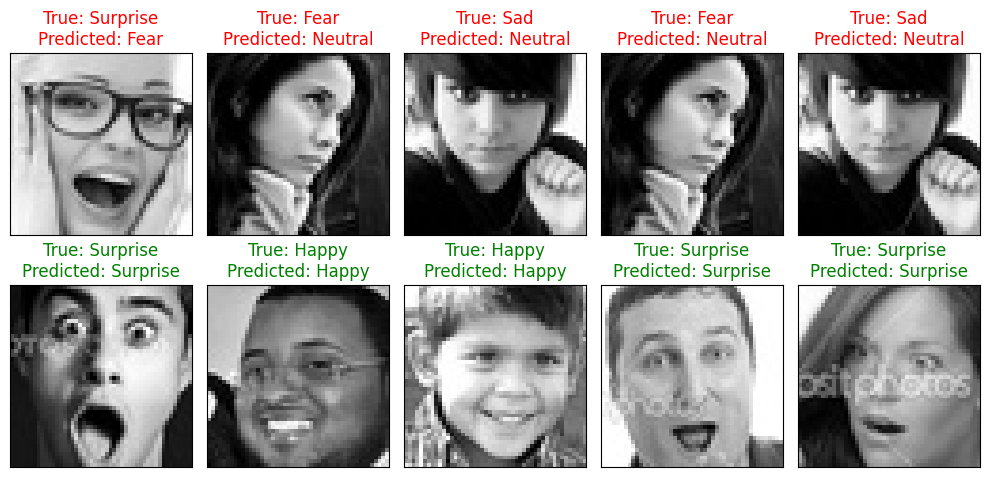

In [25]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()